In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio
import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, QTable
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline


def clear_task(task):
    """Ensure the background task has been consumed or canceled, to avoid the error report  the task's result has not been retrieved."""
    if task is None:
        return
    try:
        if task.done():
            task.result()
        else:
            task.cancel()
    except BaseException as e:
        # we don't really want any error bubbled up.
        print('clear_task() failed:', e)


<IPython.core.display.Javascript object>

# TIC 184743498

Reproducing the results in https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.3378Z/abstract

eclipsing binary + delta scuti

Authors' hypothesis: pulsating along 3 axes: 
- x-axis:  Five of these modes exhibit amplitude and phase shifts that are readily explained by a dipole pulsations axis which has been tilted into the orbital plane and which lies along the binary's tidal axis. (termed ‘Y10,x’ modes in the paper)
- y-axis: four are dipole pulsations along an axis that is perpendicular to both the tidal axis and the binary’s orbital angular momentum axis. (termed ‘Y10, y’ modes in the paper)
- z-axis: two are singlet pulsations, at least one of them is along an axis aligned with the orbital/rotation axis. (termed ‘Y10, z’ modes in the paper)
    - One of them could be radial pulsations.

Pulsation along x and y axes exhibit amplitude modulation and π-rad phase shifts twice per orbital cycle. (2 cycles per orbit)
Pulsation along z axis shows amplitudes and phases do not change significantly with orbital phase

In [2]:
#### Run All Above and this cell to start
sector, tic = 62, 184743498  # first Tri-axial stellar pulsator, close binary with a delta-scuti as the primary, with a tertiary companion, ETV -- https://ui.adsabs.harvard.edu/abs/2024MNRAS.528.3378Z/abstract

# to_download_tpf_async, to_show_tic_meta, max_num_sectors_to_download = True, False, 1  # for SSO case, skip metadata search (TCEs Gaia DR3, etc.)
# to_download_tpf_async, to_show_tic_meta, max_num_sectors_to_download = True, True, 1  # for non SSO case
to_download_tpf_async, to_show_tic_meta, max_num_sectors_to_download = False, True, 1
max_num_sectors_to_download = None   # download all sectors, set it to a number to cap it, with the supplied sector as the centor of the slice to donwload
include_first_sector = True  # include the first sector for the TIC, useful to spot changes/trend overtime.

author_priority = ["SPOC", "TESS-SPOC", "QLP", ]  # TESS-SPOC more comparable to SPOC


# one-time config for query cache
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400


def limit_sr_to_download(sr):
    if max_num_sectors_to_download is None:
            return sr
    res = lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)
    if include_first_sector and max_num_sectors_to_download > 1:
        # prepend the first sector, useful to see trend or changes over time
        first_sector_num = sr.table["sequence_number"].min()
        if first_sector_num < res.table["sequence_number"].min():
            res = lk.SearchResult(astropy.table.vstack([sr[:1].table, res.table]))
    return res

try:
    clear_task(gaiadr3_task); clear_task(metadata_html_task); clear_task(tpf_task);  # clear out tasks that might not have been retrieved.
except NameError:
    pass  # the tasks not yet defined (first invocation of the notebook). No-op

# Get Gaia DR3 info in the background (to show in this cell at the end)
gaiadr3_task = asyncio_compat.create_background_task(lket.search_gaiadr3_of_tics, tic, radius_arcsec=15, magnitude_range=2.5, pm_error_factor=None, pm_range_fraction=0.25, pm_range_minimum=1.0, compact_columns=True, also_return_html=True, also_return_astrophysical=True, verbose_html=True, include_nss_summary_in_html=True)

# Get TIC meta (stellar parameters, TCEs, TOIs/CTOIs) in the background
metadata_html_task = None
if to_show_tic_meta:
    metadata_html_task = asyncio_compat.create_background_task(lket.get_tic_meta_in_html, tic, download_dir=lk_download_dir, include_transit_model_stellar_density=True)

# Start downloading TPF asynchronously while the user inspects the lightcurve
# Users can jump to "TPF Download" section to access the result
tpf_task = None
if to_download_tpf_async:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir=lk_download_dir)

# download LCs
try:
    if max_num_sectors_to_download is not None and to_download_tpf_async is False:  # Normally I rarely download all sectors. so once I use it once I'd like to comment out the line again
        display(HTML("""<a id="input-tic-out"><script>document.getElementById("input-tic-out").scrollIntoView();</script>"""))
    # the download
    lcf_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic,
                                                                                author_priority=author_priority,
                                                                                download_filter_func=limit_sr_to_download, download_dir=lk_download_dir)
finally:
    # tplt.beep()  # a beep to remind the users that the data has been downloaded
    pass



if lcf_coll is not None:
    lc = of_sector(lcf_coll, sector)
    if lc is None:
        lc = lcf_coll[-1]
        display(HTML(f"""<span style="background-color: yellow"> WARN: <span>Tic Metadata, no LC in requested {sector}. Use sector {lc.sector}"""))
    display(HTML("""<script>document.querySelectorAll('#tic_metadata_body').forEach(e => e.remove());</script>"""))  # remove existing metadata outputs to avoid conusion

# Check if (tic, sector) is crowded
#  From section 4.1.2 of the paper TOI catalog from TESS primary mission
#  https://arxiv.org/pdf/2103.12538.pdf
# less reliable when it is < 0.8
lc = of_sector(lcf_coll, sector)
if lc is not None:
    lket.display_crowdsap(lc)
    display(HTML(f"""PDC Algo: {lc.meta.get("PDCMETHD")}, ; goodness metric: {lc.meta.get("PDC_TOT")}"""))


# Show relevant Gaia DR3 of the target (by coordinate)
if to_show_tic_meta:
    try:
        rs_all_cols, rs, rs_paramp_all_cols, rs_paramp, rs_html = await asyncio.wait_for(gaiadr3_task, timeout=5.0)
        display(HTML(f"<h4>Gaia DR3</h4>{rs_html}"))
        if rs is None:
            display(HTML("None found"))
    except Exception as e:
        display(HTML(f"""Gaia DR3. Skipped, probably timedout. {type(e)}. Go to <a href="#gaia">Gaia DR3 section</a> to try again."""))

9 rows filtered


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 08,2019,TESS-SPOC,1800,184743498,0.0,N/A
1,TESS Sector 34,2021,TESS-SPOC,600,184743498,0.0,N/A
2,TESS Sector 35,2021,TESS-SPOC,600,184743498,0.0,N/A
3,TESS Sector 61,2023,TESS-SPOC,200,184743498,0.0,N/A
4,TESS Sector 62,2023,SPOC,120,184743498,0.0,N/A


TIC 184743498 	, all available sectors: 8, 34-35, 61-62
downloaded #sectors: 5 ; 8, 34-35, 61-62
   sector 62: 	camera = 3 ; ccd = 2


In [75]:
if metadata_html_task.done():
    display(HTML(metadata_html_task.result()))
else:
    display(HTML("TIC metadata is still loading in the background"))

1496.7450341747622

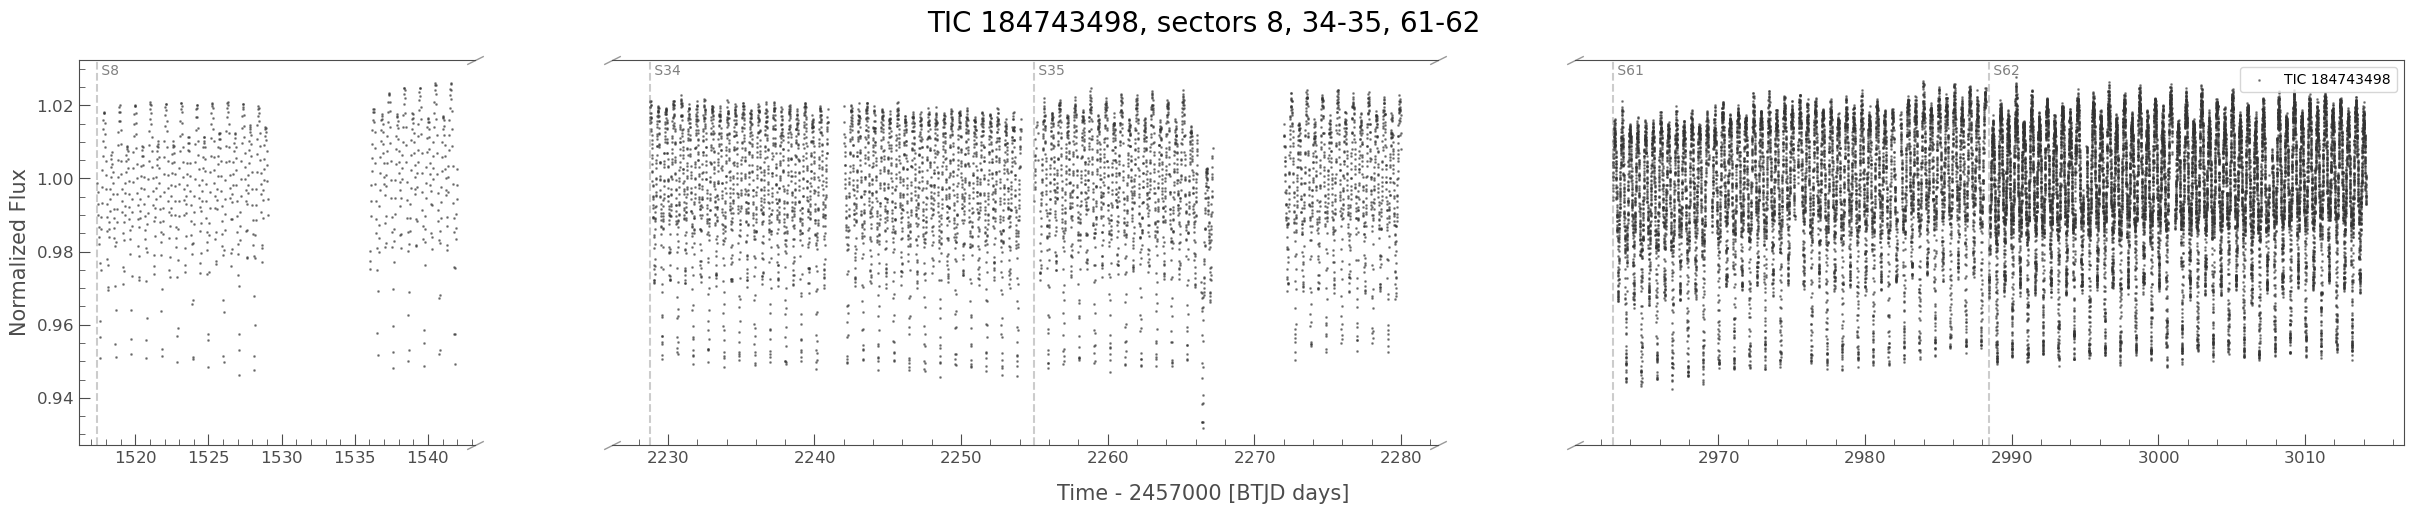

In [9]:
# reload(lke)
# reload(tplt)
# avoid normalization, because seems that FAP calc by baluev method doesn't work with normalized data
lcc_to_use = of_sectors(lcf_coll[:], )
def stitch_corrector(lc):
    lc = (lke.select_flux(lc,
                          # "flux",
                          "sap_flux",
                         )
          # .remove_outliers(sigma=5)
         )
    if len(lcc_to_use) > 1:  # can get FAP when not normalized
        lc = lc.normalize()
    return lc

lc = lke.stitch(lcc_to_use, corrector_func=stitch_corrector,ignore_incompatible_column_warning=True)
# lc = lke.exclude_range(lc, 1576, 1582)  # exclude outlier cadence
# lc = lke.bin_flux(lc, time_bin_size=30*u.min)  # bin to speed up periodogram computation
# lc = lc.truncate(97, None, column="flux") # mask eclipses crudely

mask_transits = False  # optional, mask out the transits before feeding to periodogram
# mask_transits = True
if mask_transits:
    duration_factor = 1.2  # mask out some oot cadence to ensure variation due to transits/eclipses are masked
    tmask = lc.create_transit_mask(transit_time=transit_specs.epoch, period=transit_specs.period, duration=transit_specs.duration * duration_factor)
    lc = lc[~tmask]
    display(HTML("""<b style="background-color: yellow;">Note:</b> Dips are masked."""))


axs = tplt.plot_skip_data_gap(lc, figsize=(30, 5), s=4, alpha=0.5);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
# [ax.set_ylim(99.25, None) for ax in axs];
(lc.time.max() - lc.time.min()).value

In [21]:
pg = (
    lc
#     [~tmask]
    .to_periodogram(method="lombscargle",
                     # maximum_period=2,
                       # minimum_period=10,
                       # minimum_period=0.0005, maximum_period=1,
                       # minimum_period=3, maximum_period=15,
                    # ls_method="fastchi2", nterms=2,
                    # oversample_factor=50,  # default: 5
                      )
     )
print(len(lc), lc.time.max() - lc.time.min(), lc.time.min(), lc.time.max(), )
pg.show_properties();


35790 1496.7450341747622 1517.4099189281428 3014.154953102905
lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         184743498      
          default_view                         frequency      
                 label                     TIC 184743498      
             ls_method                              fast      
frequency_at_max_power                            1.8989 1 / d
             max_power                            0.0217      
               nyquist                          359.9985 1 / d
   period_at_max_power                            0.5266     d
             frequency                  array (2694129,) 1 / d
                period                  array (2694129,)     d
                 power                  array (2694129,)      
                  met

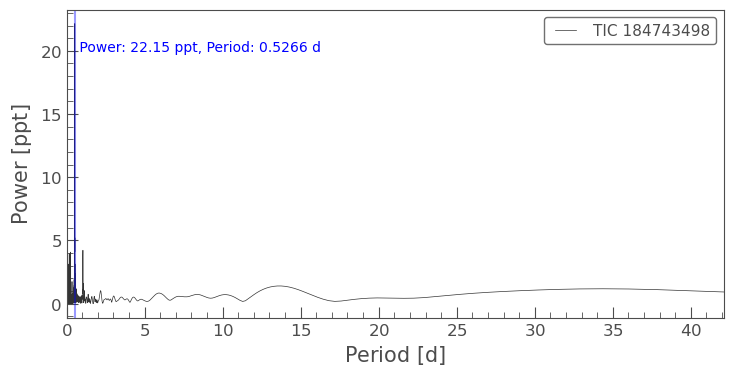

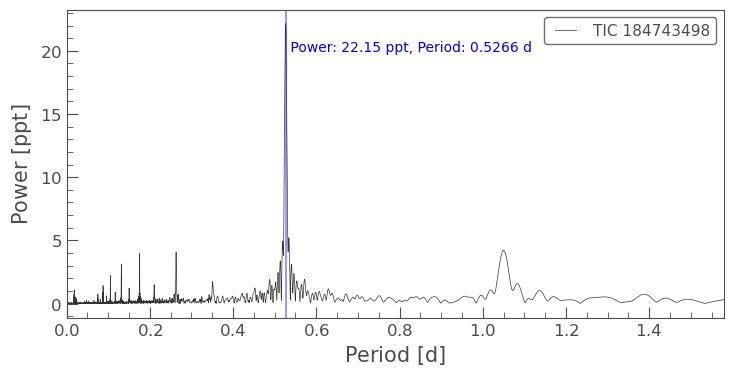

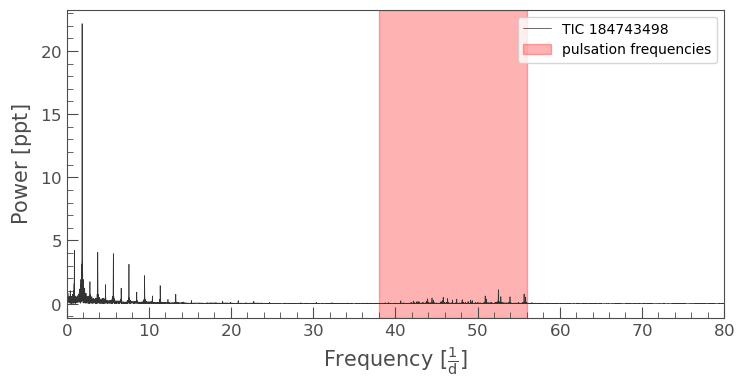

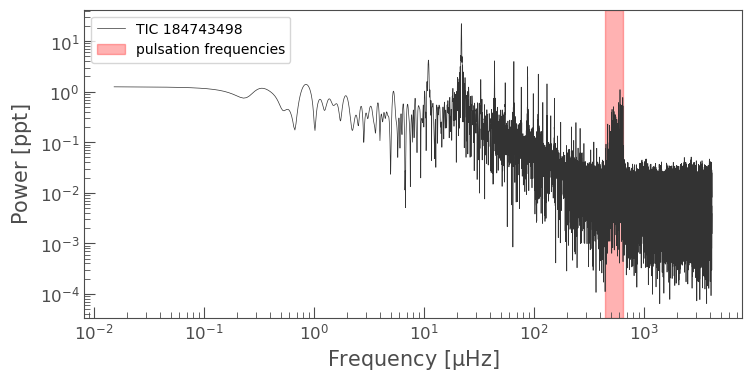

In [87]:
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=80);
# ax.set_xlim(0, 16);

# zoom in
ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=3);

# ---

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(0, 80);
ax.axvspan(38, 56, color="red", alpha=0.3, label="pulsation frequencies")
ax.legend();

# frequency in log scale / microhertz
# often useful for solar type oscillator,
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");
ax.axvspan((38 * 1/u.d).to_value(u.microhertz), (56 * 1/u.d).to_value(u.microhertz), color="red", alpha=0.3, label="pulsation frequencies")
ax.legend();


lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         184743498      
          default_view                         frequency      
                 label                     TIC 184743498      
             ls_method                              fast      
frequency_at_max_power                            1.8989 1 / d
             max_power                           22.1537   ppt
               nyquist                          360.0007 1 / d
   period_at_max_power                            0.5266     d
             frequency                   array (272241,) 1 / d
                period                   array (272241,)     d
                 power                   array (272241,)   ppt
                  meta <class 'collections.OrderedDict'>      


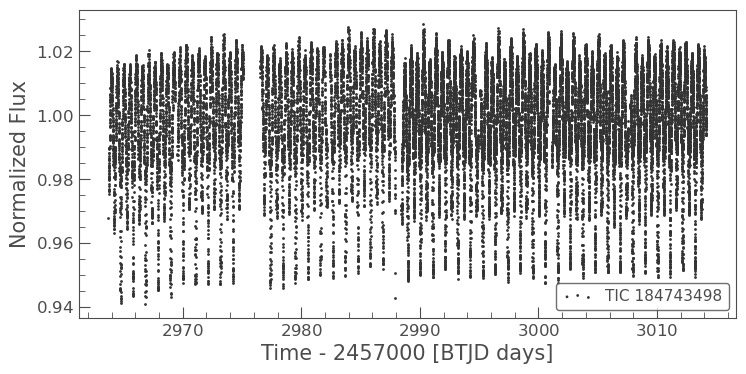

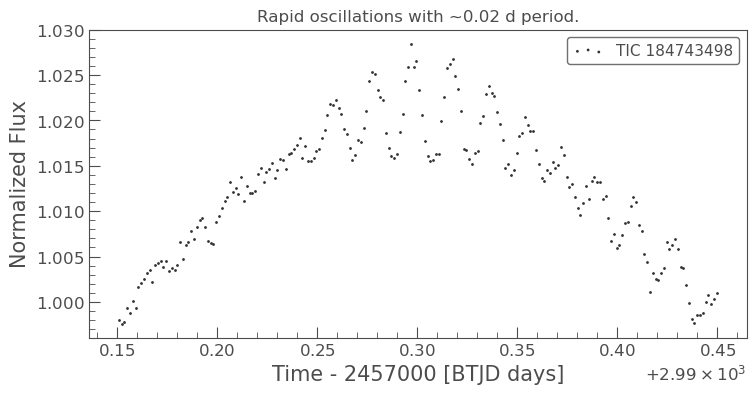

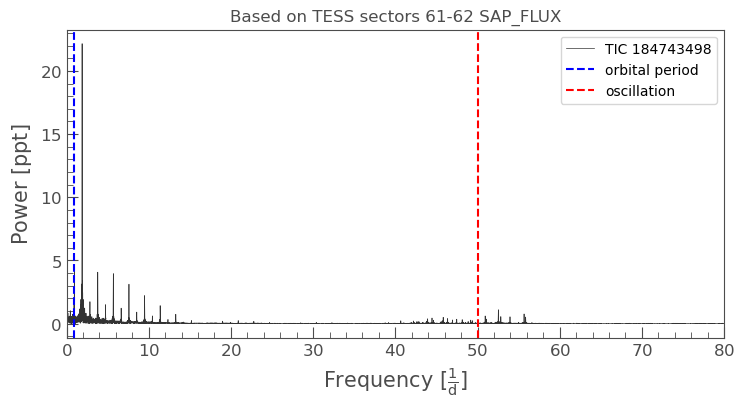

In [264]:
# Identify interesting pulsation frequencies

_lc = lke.stitch(of_sectors(lcf_coll, 61, 62))  # use the 2 sectors with 2min cadence data
ax = tplt.scatter(_lc);

ax = tplt.scatter(_lc.truncate(2990.15, 2990.45));
ax.set_title("Rapid oscillations with ~0.02 d period.")

# pg is the overall periodogram across all sectors
pg = _lc.to_periodogram(
    method="lombscargle",
    oversample_factor=15,  # default: 5
)
pg.power = pg.power.to("ppt")  # use paper's unit
pg.show_properties()
ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(0, 80);
ax.set_title("Based on TESS sectors 61-62 SAP_FLUX");
ax.axvline(1 / 1.053240, color="blue", linestyle="--", label="orbital period");
ax.axvline(50, color="red", linestyle="--", label="oscillation");
ax.legend();

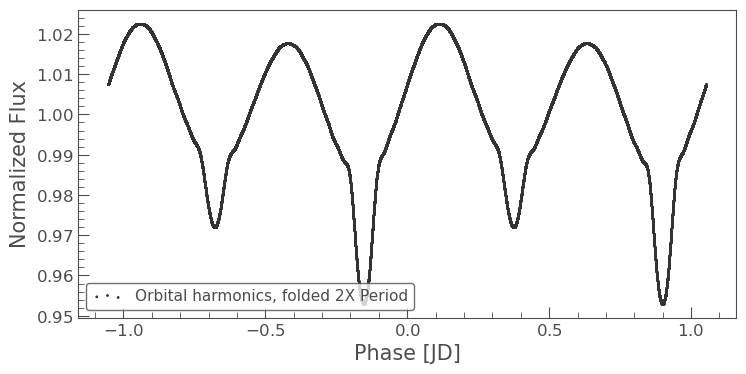

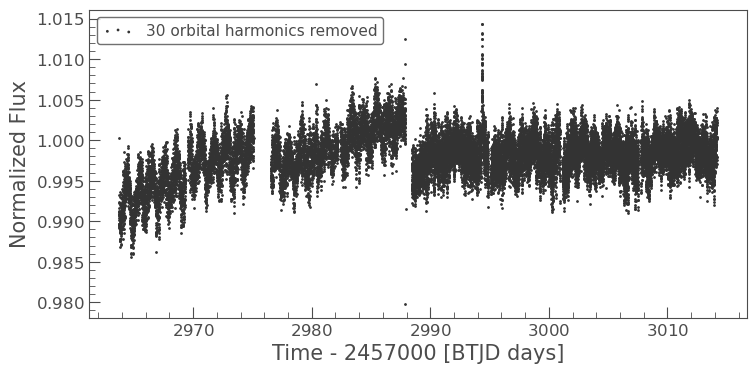

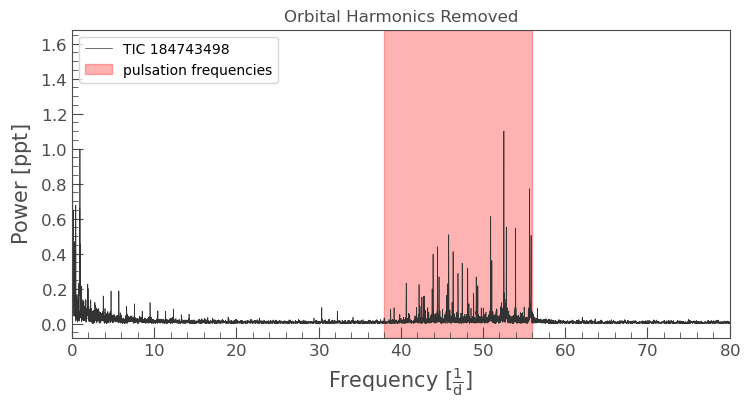

In [265]:
# reload(lke_pg)

orbital_frequency = pg.frequency_at_max_power / 2  # from above periodogram
# orbital_frequency = (41.6152 - 40.6653) * (1/u.d)  # from the value in the paper table 4


_lc_orbital_model = lke_pg.create_model_lc_of_frequencies(_lc, pg, orbital_frequency * [n for n in range(1, 31)])
_lc_orbital_model.fold(period=(1 / orbital_frequency) * 2).scatter(label="Orbital harmonics, folded 2X Period");

_lc_residual = lke_pg.remove_harmonics(_lc, pg, orbital_frequency, 30)
ax = tplt.scatter(_lc_residual, label="30 orbital harmonics removed");

pg_residual = _lc_residual.to_periodogram(method="lombscargle",)
pg_residual.power = pg_residual.power.to("ppt")  # use paper's unit
ax = pg_residual.plot(view="frequency");  # frequency view
ax.set_xlim(0, 80);
ax.set_title("Orbital Harmonics Removed");
ax.axvspan(38, 56, color="red", alpha=0.3, label="pulsation frequencies")
ax.legend();


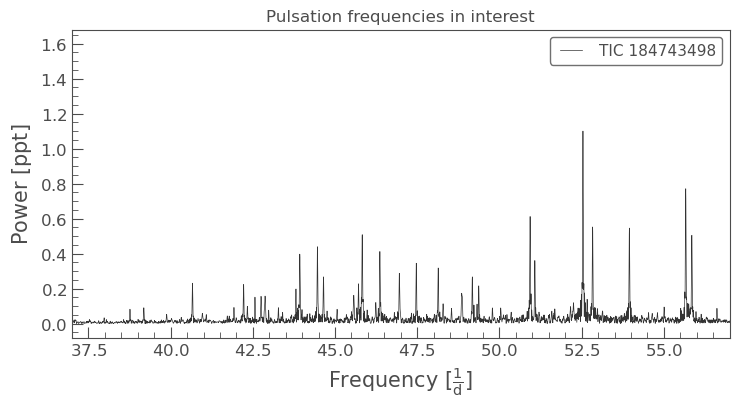

In [266]:
ax = pg_residual.plot(view="frequency");  # frequency view
ax.set_xlim(37, 57);  # 38 - 56 1/d in the paper, add some margin
ax.set_title("Pulsation frequencies in interest");


The dominant pulsation frequencies, annotated with the proposed pulsation axes.

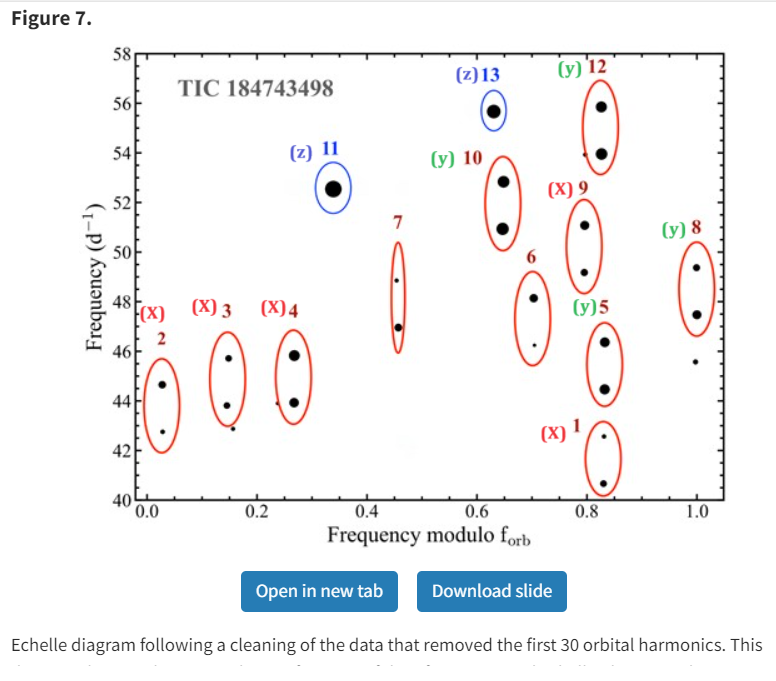

Frequencies (6) and (7): their phases and amplitudes were not robustly characterized

numax: 48.95 1 / d (method: ACF2D)

deltanu: 3.02 1 / d (method: ACF2D)

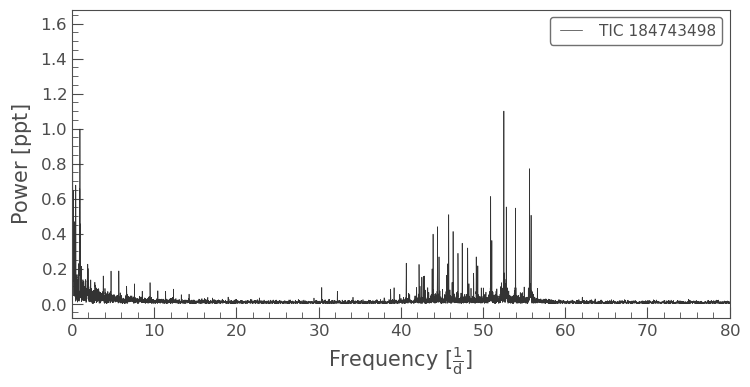

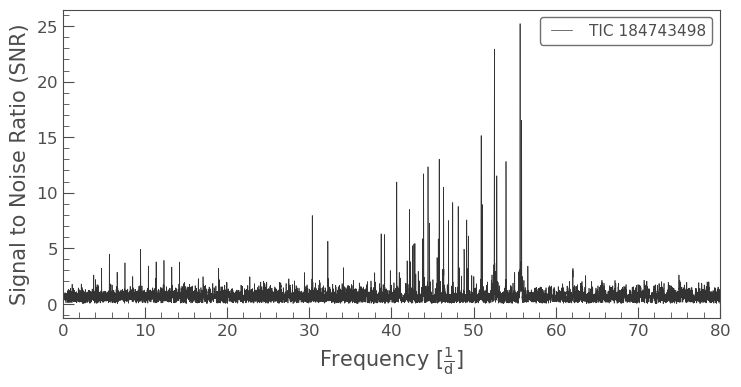

In [285]:
ax = pg_residual.plot();
ax.set_xlim(0, 80);

ax = pg_residual.flatten().plot();  # .to_seismology()
ax.set_xlim(0, 80);

seismology = pg_residual.flatten().to_seismology()
display(seismology.estimate_numax())
display(seismology.estimate_deltanu())

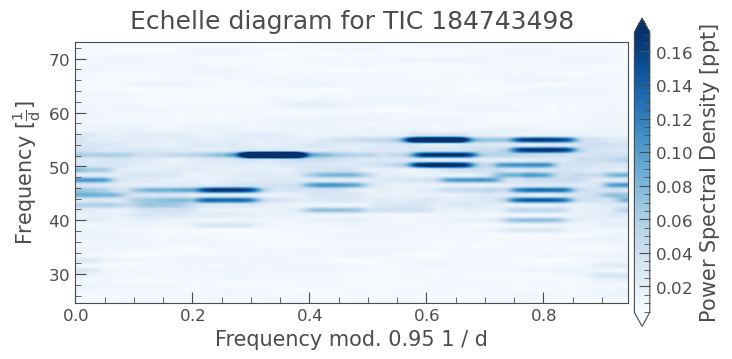

In [284]:
ax = seismology.plot_echelle(
    deltanu=(42.5627706 - 40.66254065) / 2,
    );


In [174]:
peaks = lke_pg.find_peaks(
    pg_residual[(38 * (1/u.d) < pg_residual.frequency) & (pg_residual.frequency < 56 * (1/u.d))]
)
peaks["rank"] = np.linspace(1, len(peaks), len(peaks), dtype=int)

peaks.sort("frequency")
with astropy.conf.set_temp("max_lines", 999):
    display(peaks[peaks["rank"] <= 40])
    # peaks[peaks["rank"] <= 40].to_pandas().to_clipboard(index=False)

power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,rank
ppt,1 / d,,1 / d,1 / d,1 / d,,
float64,float64,float64,float64,float64,float64,float64,int32
0.09091263857083812,39.18282087727054,0.09024164463331395,-0.011179,+0.013558,0.024736,1.341,36
0.2310968165064132,40.66254064918731,0.22980434837154373,-0.011302,+0.013945,0.025247,1.292,17
0.09271973060479043,41.924071178596236,0.08997044592492093,-0.010453,+0.014101,0.024554,1.253,37
0.22398107327576633,42.21763488669769,0.2226603409167357,-0.011774,+0.013665,0.025439,1.245,19
0.09958371859658231,42.33268012365637,0.09575673648874493,-0.012386,+0.013139,0.025525,1.241,34
0.15153558110641602,42.56277059757372,0.14980072879420905,-0.011469,+0.0151,0.02657,1.234,26
0.15624250632040756,42.74922322298951,0.15001792317504214,-0.013742,+0.014373,0.028114,1.229,25
0.1576426629579637,42.872202614221194,0.15615609509720146,-0.022552,+0.015344,0.037896,1.226,24


### Approximate part of figure 8

- for the pulsation frequencies of which pulsation amplitude maxima correspond to eclipses
- hypothesis: pulsation axis is along tidal axis

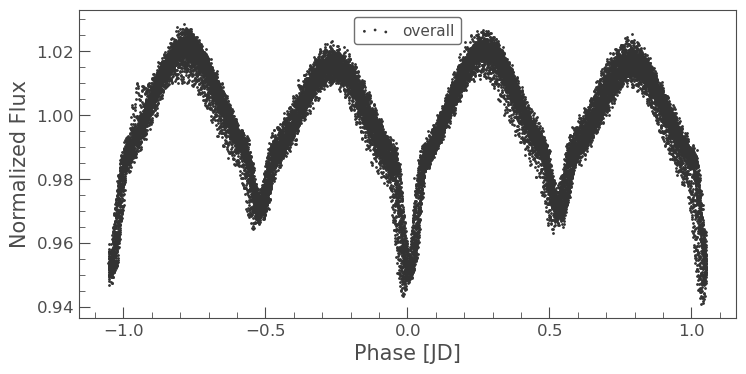

v1: 41.612655625, v_orb: 0.9501149750000017
v1 set: [39.71242567 40.66254065 41.61265563 42.5627706  43.51288558] 1 / d


power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,rank
ppt,1 / d,,1 / d,1 / d,1 / d,,
float64,float64,float64,float64,float64,float64,float64,int32
0.2310968165064132,40.66254064918731,0.22980434837154373,-0.011302,+0.013945,0.025247,1.292,17
0.15153558110641602,42.56277059757372,0.14980072879420905,-0.011469,+0.0151,0.02657,1.234,26


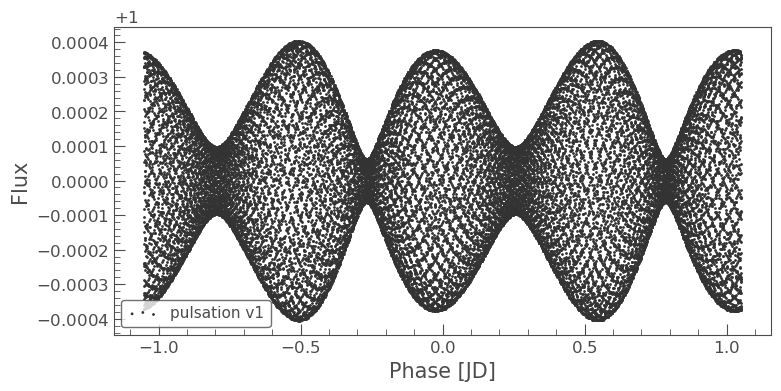

v4 set: [42.97733015 43.92744513 44.87756011 45.82767508 46.77779006] 1 / d


power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,rank
ppt,1 / d,,1 / d,1 / d,1 / d,,
float64,float64,float64,float64,float64,float64,float64,int32
0.3970894389121126,43.92744513253181,0.3939560904290782,-0.012163,+0.013344,0.025507,1.196,10
0.5083177645869439,45.82767508091822,0.5070425408208553,-0.013193,+0.011502,0.024695,1.146,6


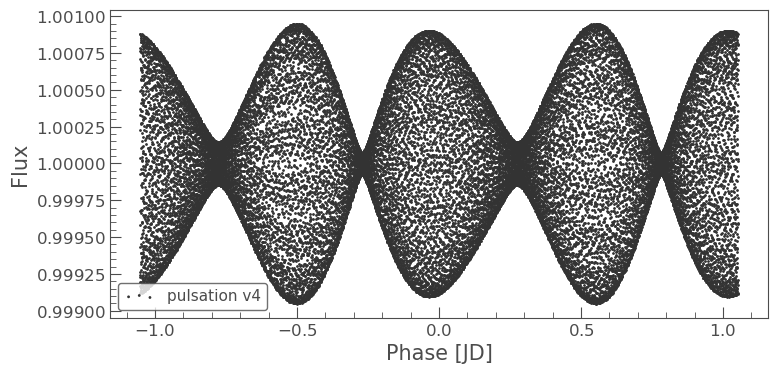

In [182]:
ax = _lc.fold(period=1/v_orb * 2, epoch_time=Time(2459988.9789, format="jd", scale="tdb").to_value("btjd")).scatter(label="overall");
plt.show()

v1 = (42.5627706 + 40.66254065) / 2
v_orb = (42.5627706 - 40.66254065) / 2
print(f"v1: {v1}, v_orb: {v_orb}")
v1_freq_set = np.array([v1 + v_orb * i for i in range(-2, 3)]) * (1/u.d)  # the paper uses 5 frequencies around v1
# v1_freq_set = np.array([v1 + v_orb * i for i in (-1, 1)]) * (1/u.d)  # only -1, +1 is significant
print("v1 set:", v1_freq_set)
display(astropy.table.vstack([
    peaks[np.isclose(peaks["frequency"], f)]
    for f in v1_freq_set.value
]))

lc_v1 = lke_pg.create_model_lc_of_frequencies(_lc_residual, pg_residual, v1_freq_set)
ax = lc_v1.fold(period=1/v_orb * 2, epoch_time=Time(2459988.9789, format="jd", scale="tdb").to_value("btjd")).scatter(label="pulsation v1");
plt.show()

#---

v4 = (45.82767508 +  43.92744513) / 2
v4_freq_set = np.array([v4 + v_orb * i for i in range(-2, 3)]) * (1/u.d)  # the paper uses 5 frequencies around v1
print("v4 set:", v4_freq_set)
display(astropy.table.vstack([
    peaks[np.isclose(peaks["frequency"], f)]
    for f in v4_freq_set.value
]))

lc_v4 = lke_pg.create_model_lc_of_frequencies(_lc_residual, pg_residual, v4_freq_set)
ax = lc_v4.fold(period=1/v_orb * 2, epoch_time=Time(2459988.9789, format="jd", scale="tdb").to_value("btjd")).scatter(label="pulsation v4");


### Approximate part of figure 9

- for the pulsation frequencies of which pulsation amplitude maxima correspond to ellipsoidal variation peaks
- hypothesis: pulsation axis is along a "y-axis", perpendicular to tidal axis (x) and the orbital angular momentum (rotation) axis (z).
    - the authors reject the (more obvious) explanation that it is a tidally tilted pulsation axis (section 6)


In [141]:
# TODO:

### Reconstruct pulsation for singlet frequencies

- the 2 singlet frequencies have no variation in pulsation amplitude
- they have the largest amplitude, and correspond to rapid oscillation (with ~0.02 d period) seen in the raw lightcurves

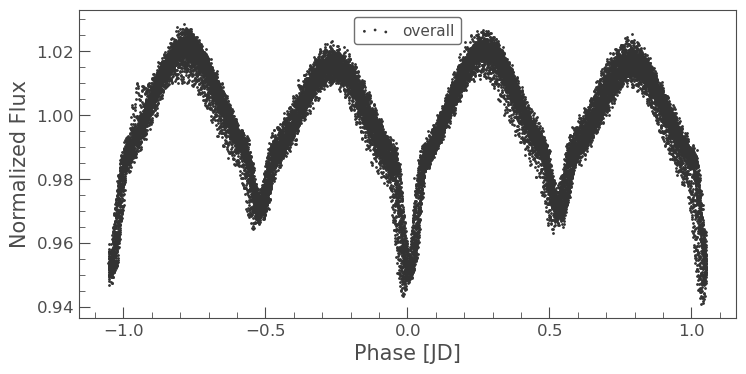

power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,rank
ppt,1 / d,,1 / d,1 / d,1 / d,,
float64,float64,float64,float64,float64,float64,float64,int32
1.1003417955330066,52.539969595886504,1.0995728583846953,-0.01254,+0.012796,0.025336,1.000,1


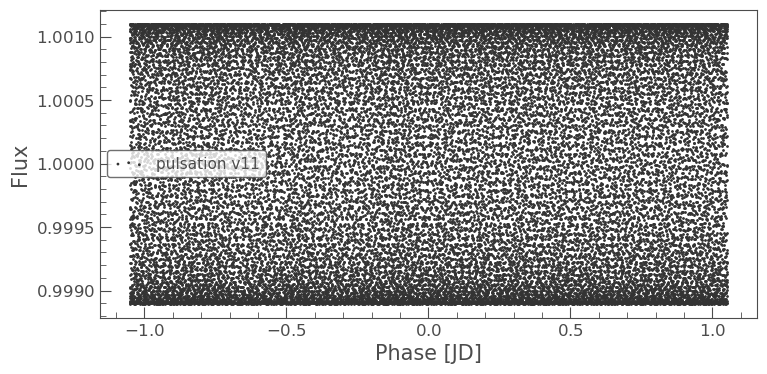

power,frequency,prominence,lower_hwhm,upper_hwhm,fwhm,frequency_ratio,rank
ppt,1 / d,,1 / d,1 / d,1 / d,,
float64,float64,float64,float64,float64,float64,float64,int32
0.770851315178919,55.66602637945329,0.7676958429005276,-0.013138,+0.012338,0.025476,0.944,2


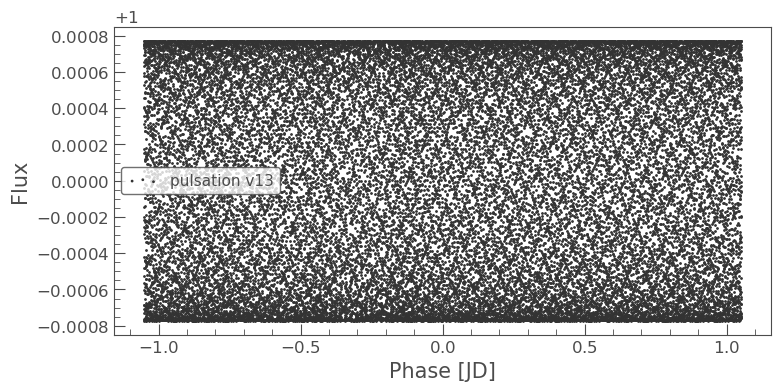

In [181]:
ax = _lc.fold(period=1/v_orb * 2, epoch_time=Time(2459988.9789, format="jd", scale="tdb").to_value("btjd")).scatter(label="overall");
plt.show()


v11 = 52.5399696
v11_freq_set = np.array([v11, ]) * (1/u.d)
display(astropy.table.vstack([
    peaks[np.isclose(peaks["frequency"], f)]
    for f in v11_freq_set.value
]))


lc_v11 = lke_pg.create_model_lc_of_frequencies(_lc_residual, pg_residual, v11_freq_set)
ax = lc_v11.fold(period=1/v_orb * 2, epoch_time=Time(2459988.9789, format="jd", scale="tdb").to_value("btjd")).scatter(label="pulsation v11");
plt.show()

# ---

v13 = 55.66602638
v13_freq_set = np.array([v13, ]) * (1/u.d)
display(astropy.table.vstack([
    peaks[np.isclose(peaks["frequency"], f)]
    for f in v13_freq_set.value
]))

lc_v13 = lke_pg.create_model_lc_of_frequencies(_lc_residual, pg_residual, v13_freq_set)
ax = lc_v13.fold(period=1/v_orb * 2, epoch_time=Time(2459988.9789, format="jd", scale="tdb").to_value("btjd")).scatter(label="pulsation v13");


## VSX Revision

https://www.aavso.org/vsx/index.php?view=detail.top&oid=426516

In [132]:
primary_name = "GDS_J0831116-390645"  # the name in the existing VSX entry

In [10]:
display(HTML(rs_html))

target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (127.7985391, -39.11261686)>

In [181]:
# Orbital params from the paper

epoch_time = Time(2459988.9789, format="jd", scale="tdb")  # Table 4
epoch_time_btjd = epoch_time.to_value(format="btjd")
epoch_time_hjd = lke.to_hjd_utc(epoch_time, target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 4)  # for VSX reporting, use 4 digits to be the same as the paper

period = 1.053245  # Table 2, based on TESS and ASAS3 ETV

duration_hr = 2.4833  # primary eclipse duration, from TCE

In [153]:
# DSCT params from the paper

dsct_freq = 52.5418	 # Table 4, in units 1/d
dsct_period = 1 / dsct_freq

# determine the precision of the DSCT period to be reported
# by matching it with the frequency with error the one listed on table 4
freq_err = 0.0006  # table 4


for num_digits in range(4, 10):
    if dsct_freq - freq_err < 1 / round(dsct_period, num_digits) < dsct_freq + freq_err:
        print(
            num_digits,
            dsct_freq, dsct_freq + freq_err , dsct_freq - freq_err,
            1 / round(dsct_period, num_digits),
        )
        break

dsct_period = round(dsct_period, num_digits)
print("DSCT period, rounded:", dsct_period)

7 52.5418 52.5424 52.5412 52.54170497832654
DSCT period, rounded: 0.0190325


In [135]:
import lightkurve_ext_readers as lker
# reload(lker)

lc_asas3 = lker.read_asas3("https://www.astrouw.edu.pl/cgi-asas/asas_cgi_get_data?083112-3906.8,asas3")


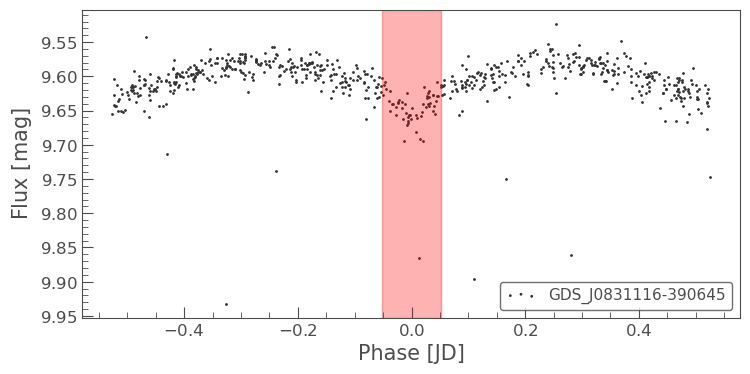

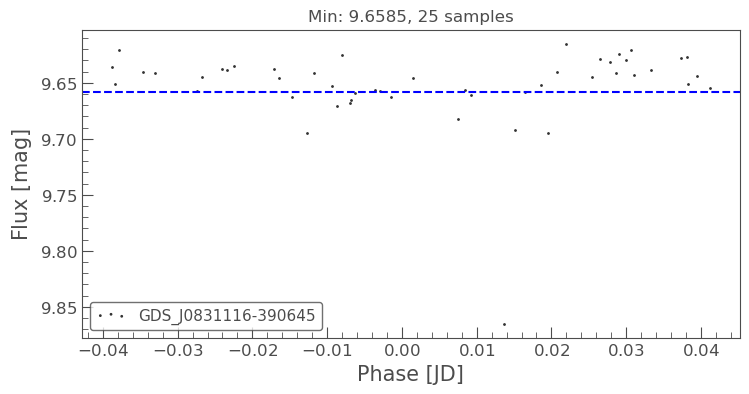

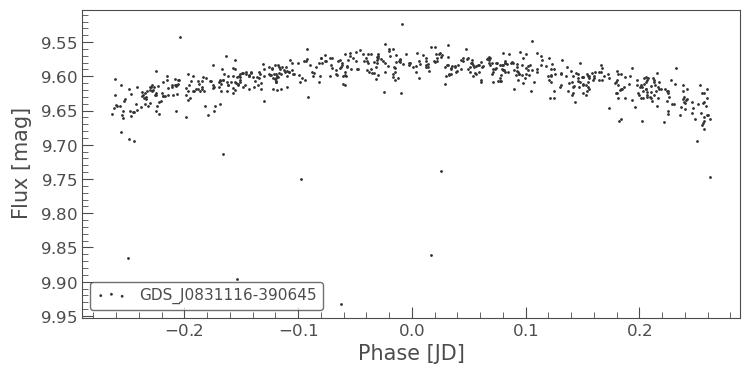

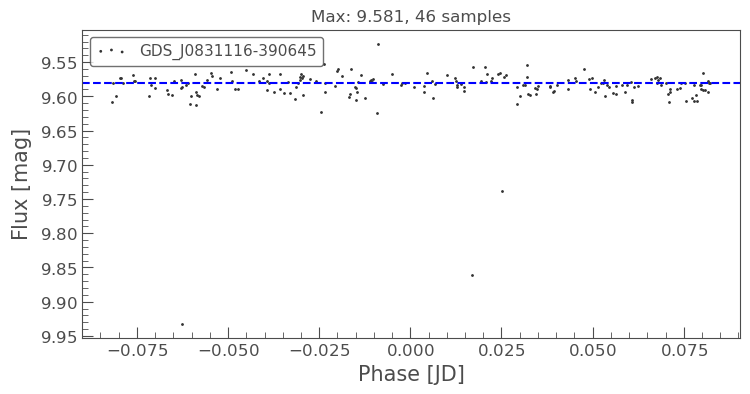

In [136]:
# Determine magnitude range

lc = lc_asas3.copy()
lc.label = primary_name

lc_f = lc.fold(period=period, epoch_time=epoch_time_hjd)
ax = tplt.scatter(lc_f);
ax.axvspan(0 - duration_hr/2/24, 0 + duration_hr/2/24, color="red", alpha=0.3);

lc_f_min_samples = lc_f.truncate(0 - 30/60/24, 0 + 30/60/24)
mag_min, mag_min_num_samples = np.nanmedian(lc_f_min_samples.flux.value), len(lc_f_min_samples)

ax = tplt.scatter(lc_f.truncate(0 - 60/60/24, 0 + 60/60/24));
ax.axhline(mag_min, color="blue", linestyle="--", label="min");
ax.set_title(f"Min: {mag_min}, {mag_min_num_samples} samples")

lc_f2 = lc.fold(period=period/2, epoch_time=epoch_time_hjd + period / 4)  # for (ellipsoidal) max
tplt.scatter(lc_f2)

lc_f_max_samples = lc_f2.truncate(0 - 30/60/24, 0 + 30/60/24)
mag_max, mag_max_num_samples = np.nanmedian(lc_f_max_samples.flux.value), len(lc_f_max_samples)
ax = tplt.scatter(lc_f2.truncate(0 - 120/60/24, 0 + 120/60/24));
ax.axhline(mag_max, color="blue", linestyle="--", label="max");
ax.set_title(f"Max: {mag_max}, {mag_max_num_samples} samples");

# ax, lc_f_dict = lkem.fold_n_plot_multi_bands(dict(TESS=lc), period=period, epoch=epoch_time_hjd, phase_scale=2, target_name=primary_name);


In [63]:
lc_tess = lcf_coll.stitch();
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess);

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)


(0.040000000000000924, 0.018000000000000682, 0.034999999999998366)

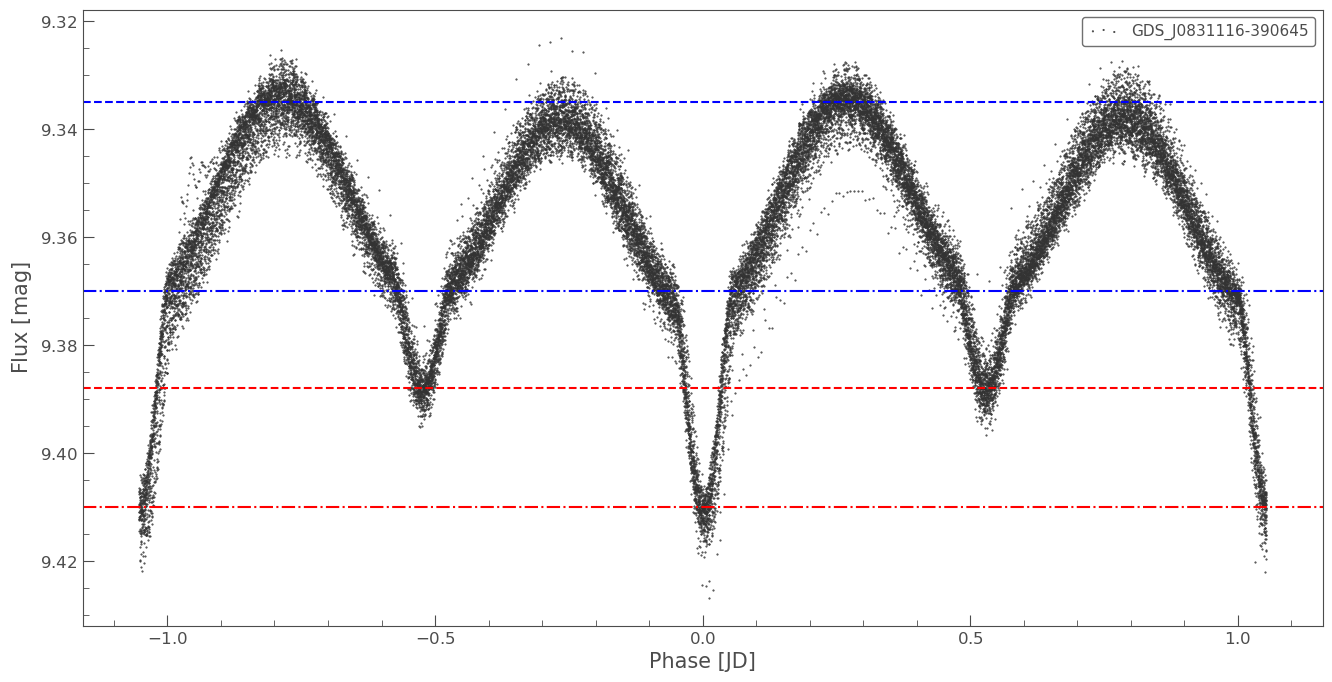

In [154]:
# Determine eclipse / ELL amplitudes

lc = lc_tess.copy()
lc.label = primary_name

lc_f = lc.fold(period=period * 2, epoch_time=epoch_time_hjd)

ax = tplt.lk_ax(figsize=(16, 8))
ax = tplt.scatter(lc_f, ax=ax, s=1);

tess_max = 9.335
tess_ell_min = 9.37
tess_min_i = 9.41
tess_min_ii = 9.388

ax.axhline(tess_max, color="blue", linestyle="--");
ax.axhline(tess_ell_min, color="blue", linestyle="-.");
ax.axhline(tess_min_ii, color="red", linestyle="--");
ax.axhline(tess_min_i, color="red", linestyle="-.");

min_i_amplitude = tess_min_i - tess_ell_min
min_ii_amplitude = tess_min_ii - tess_ell_min
ell_amplitude = tess_ell_min - tess_max

min_i_amplitude, min_ii_amplitude, ell_amplitude

lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
              targetid                         184743498      
          default_view                         frequency      
                 label               GDS_J0831116-390645      
             ls_method                              fast      
frequency_at_max_power                             1.899 1 / d
             max_power                            0.0222      
               nyquist                          360.0007 1 / d
   period_at_max_power                            0.5266     d
             frequency                   array (907470,) 1 / d
                period                   array (907470,)     d
                 power                   array (907470,)      
                  meta <class 'collections.OrderedDict'>      
v_orb:  0.9495199126

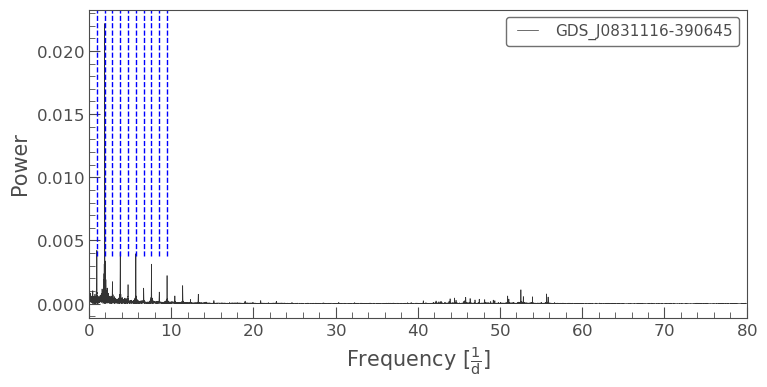

In [176]:
lc = of_sectors(lcf_coll, 61, 62).stitch()
lc.label = primary_name

pg = lc.to_periodogram(oversample_factor=50);
pg.show_properties();

# for the purpose of this frequency analysis,
# orbital frequency is chosen based on periodogram of the 2 sectors of data (rather than overall fits)
v_orb = pg.frequency_at_max_power / 2
print("v_orb: ", v_orb, "or ", 1/v_orb)

ax = pg.plot(view="frequency");
ax.set_xlim(0, 80);
ax.vlines(
    v_orb * range(1, 11),
    0.2, 1, transform=ax.get_xaxis_transform(),
    color="blue", linestyle="--", linewidth=1,
    label="orbital frequency harmonics"
);

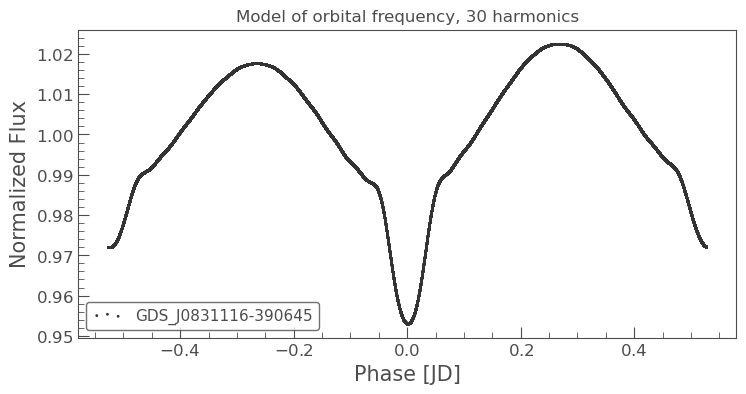

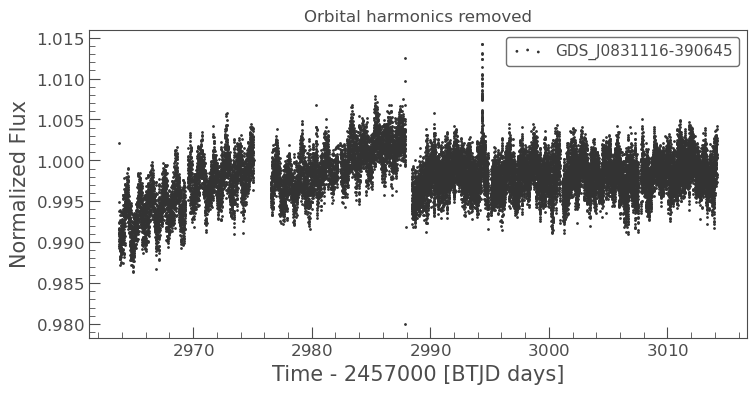

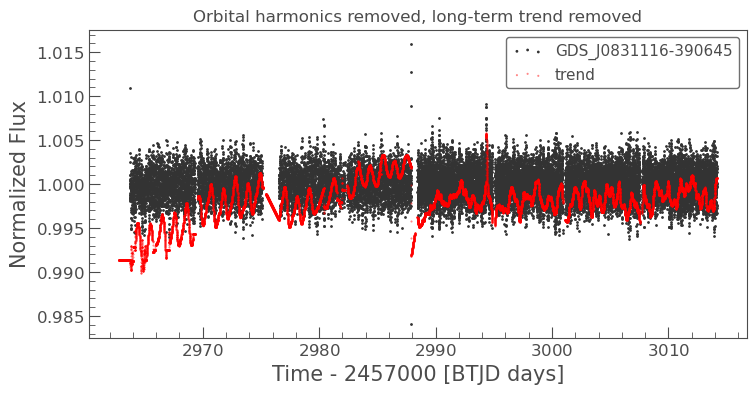

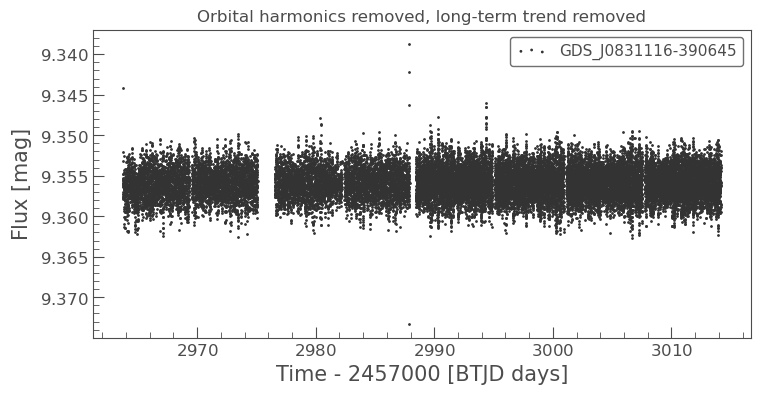

In [210]:
reload(lke_pg)

lc_orb = lke_pg.create_model_lc_of_frequencies(lc, pg, v_orb * range(1, 31))
ax = tplt.scatter(lc_orb.fold(period=1/v_orb, epoch_time=epoch_time_btjd));
ax.set_title("Model of orbital frequency, 30 harmonics")

lc_dsct = lc / lc_orb
ax = tplt.scatter(lc_dsct)
ax.set_title("Orbital harmonics removed");

lc_dsct_original = lc_dsct
lc_dsct, lc_dsct_trend = lc_dsct.flatten(lke.to_window_length_for_2min_cadence(6/24), return_trend=True)
ax = tplt.scatter(lc_dsct)
ax = tplt.scatter(lc_dsct_trend, ax=ax, color="red", s=1, alpha=0.5, label="trend")
ax.set_title("Orbital harmonics removed, long-term trend removed");

lc_dsct = lke.to_flux_in_mag_by_normalization(lc_dsct)
ax = tplt.scatter(lc_dsct)
ax.set_title("Orbital harmonics removed, long-term trend removed");



9.357087595082923 108
9.354448828278041 104
DSCT amplitude: 0.0026387668048819535
DSCT amplitude, rounded 0.003


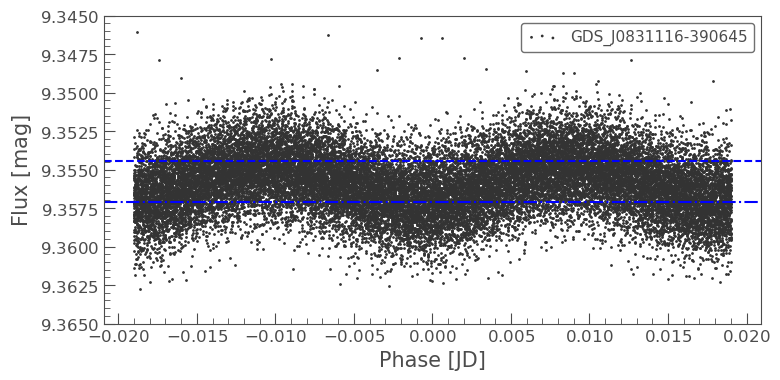

In [239]:
epoch_dsct_btjd = epoch_time_btjd - 0.0040

lc_dsct_f = lc_dsct.fold(period=dsct_period, epoch_time=epoch_dsct_btjd)

lc_dsct_f_min_samples = lc_dsct_f.truncate(0 - 0.05/60/24, 0 + 0.05/60/24)
min_dsct, min_dsct_num_samples = np.nanmedian(lc_dsct_f_min_samples.flux.value), len(lc_dsct_f_min_samples);
print(min_dsct, min_dsct_num_samples)

# ax = tplt.scatter(lc_dsct_f, s=1);
# ax.axhline(min_dsct, color="blue", linestyle="--");

lc_dsct_f2 = lc_dsct.fold(period=dsct_period, epoch_time=epoch_dsct_btjd + dsct_period / 2)

lc_dsct_f_max_samples = lc_dsct_f2.truncate(0 - 0.05/60/24, 0 + 0.05/60/24)
max_dsct, max_dsct_num_samples = np.nanmedian(lc_dsct_f_max_samples.flux.value), len(lc_dsct_f_max_samples);
print(max_dsct, max_dsct_num_samples)

# ax = tplt.scatter(lc_dsct_f2, s=1);
# ax.axhline(max_dsct, color="blue", linestyle="--");


ax = tplt.scatter(lc_dsct.fold(period=dsct_period * 2, epoch_time=epoch_dsct_btjd));
ax.axhline(max_dsct, color="blue", linestyle="--");
ax.axhline(min_dsct, color="blue", linestyle="-.");
ax.set_ylim(9.365, 9.345);

dsct_amplitude = min_dsct - max_dsct
print("DSCT amplitude:", dsct_amplitude)
dsct_amplitude = round(float(dsct_amplitude), 3)
print("DSCT amplitude, rounded:", dsct_amplitude)


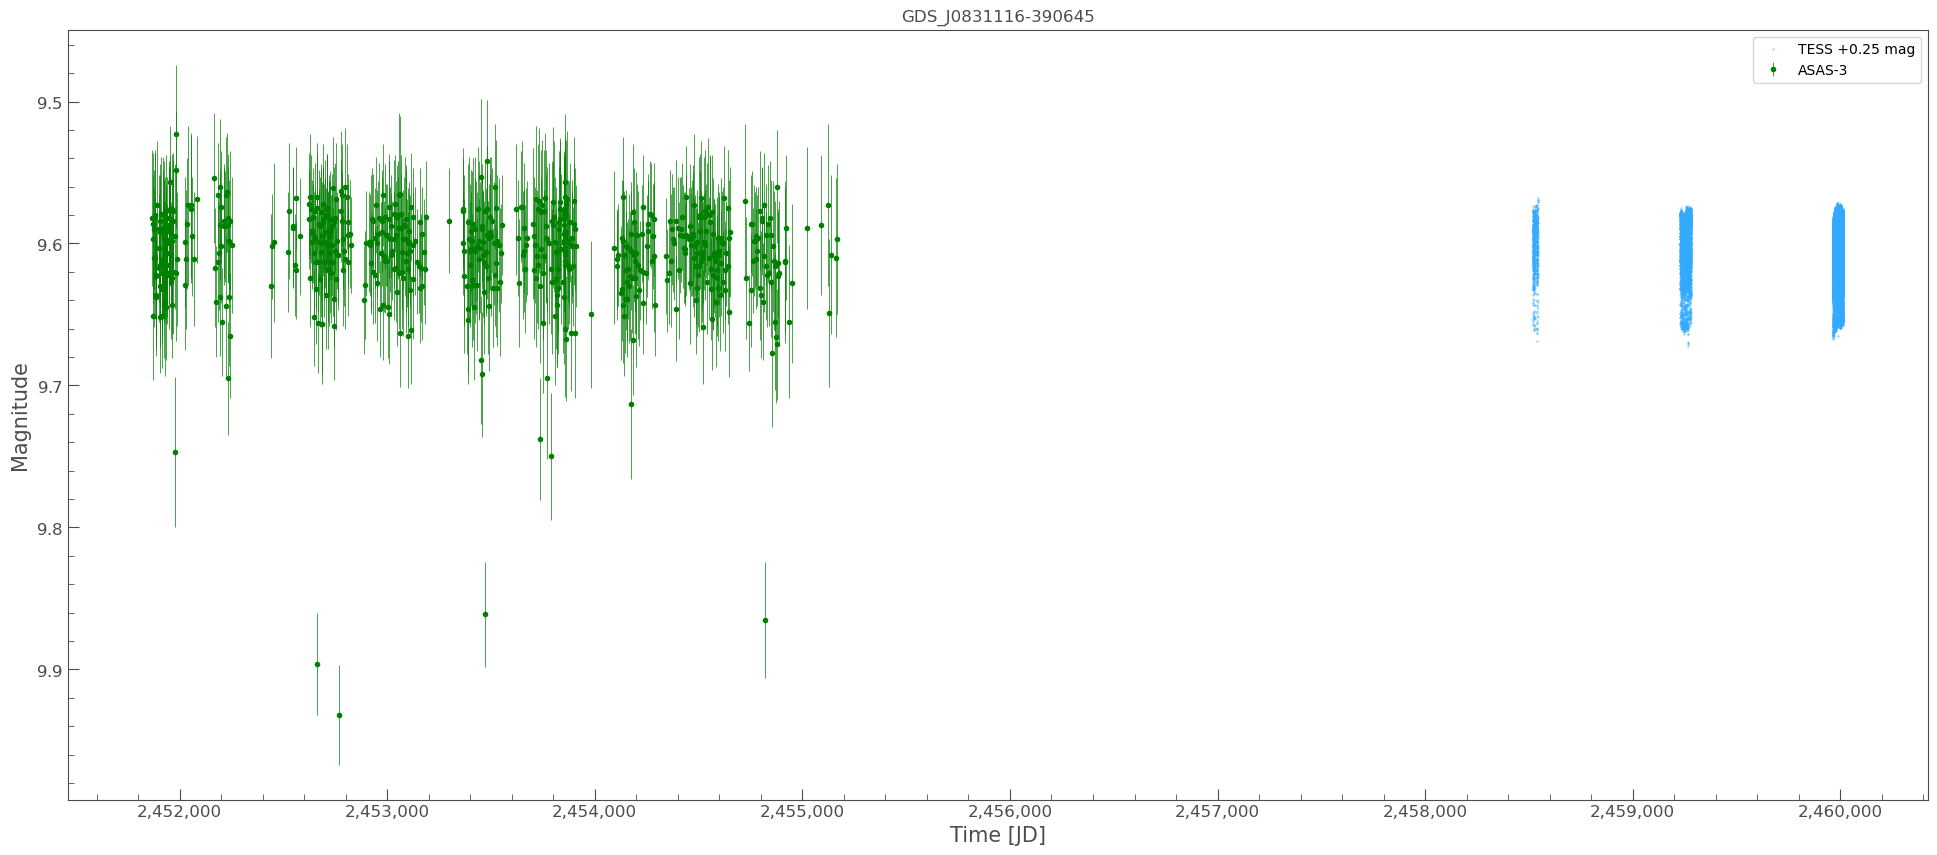

In [133]:
import lightkurve_ext_multi_sources as lkem
reload(lkem)

lc_combined_dict = lkem.combine_multi_bands_and_shift({"TESS": lc_tess, "ASAS-3": lc_asas3}, shift_to="ASAS-3")

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name);

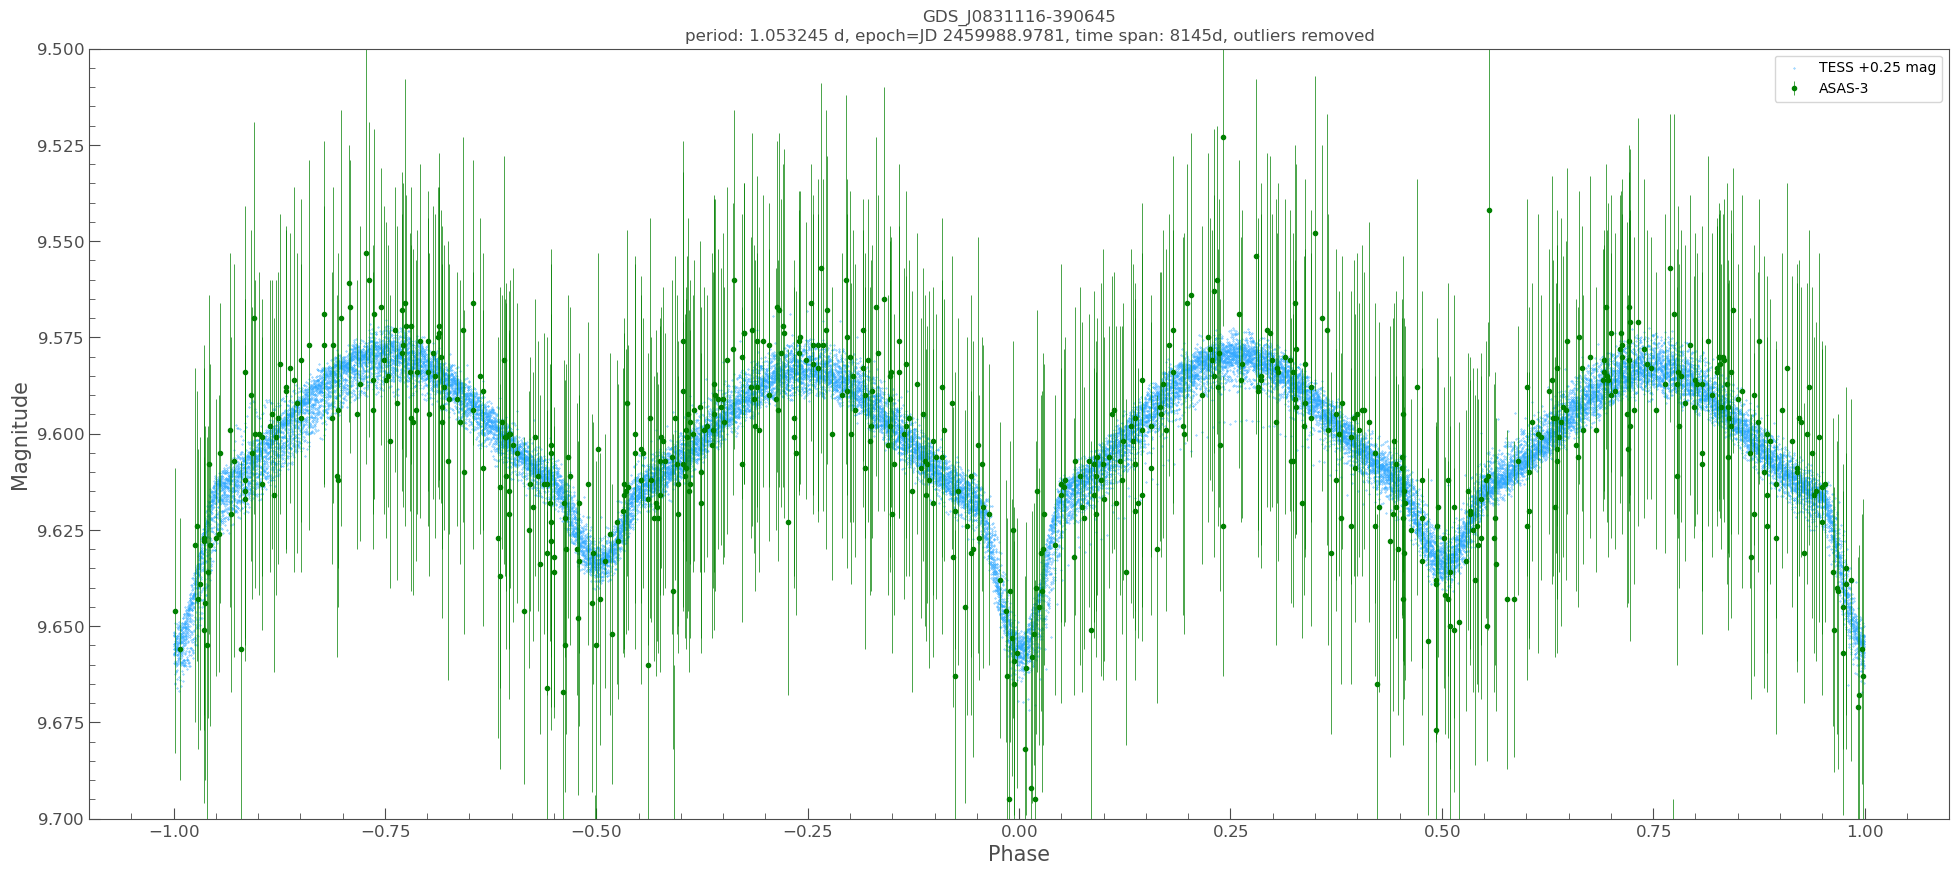

In [260]:
ax, lc_f_dict = lkem.fold_n_plot_multi_bands(lc_combined_dict, period=period, epoch=Time(epoch_time_hjd, format="jd", scale="utc"), phase_scale=2, figsize=(24, 10), target_name=primary_name);
ax.set_ylim(9.70, 9.5);
ax.set_title(ax.get_title() + ", outliers removed");

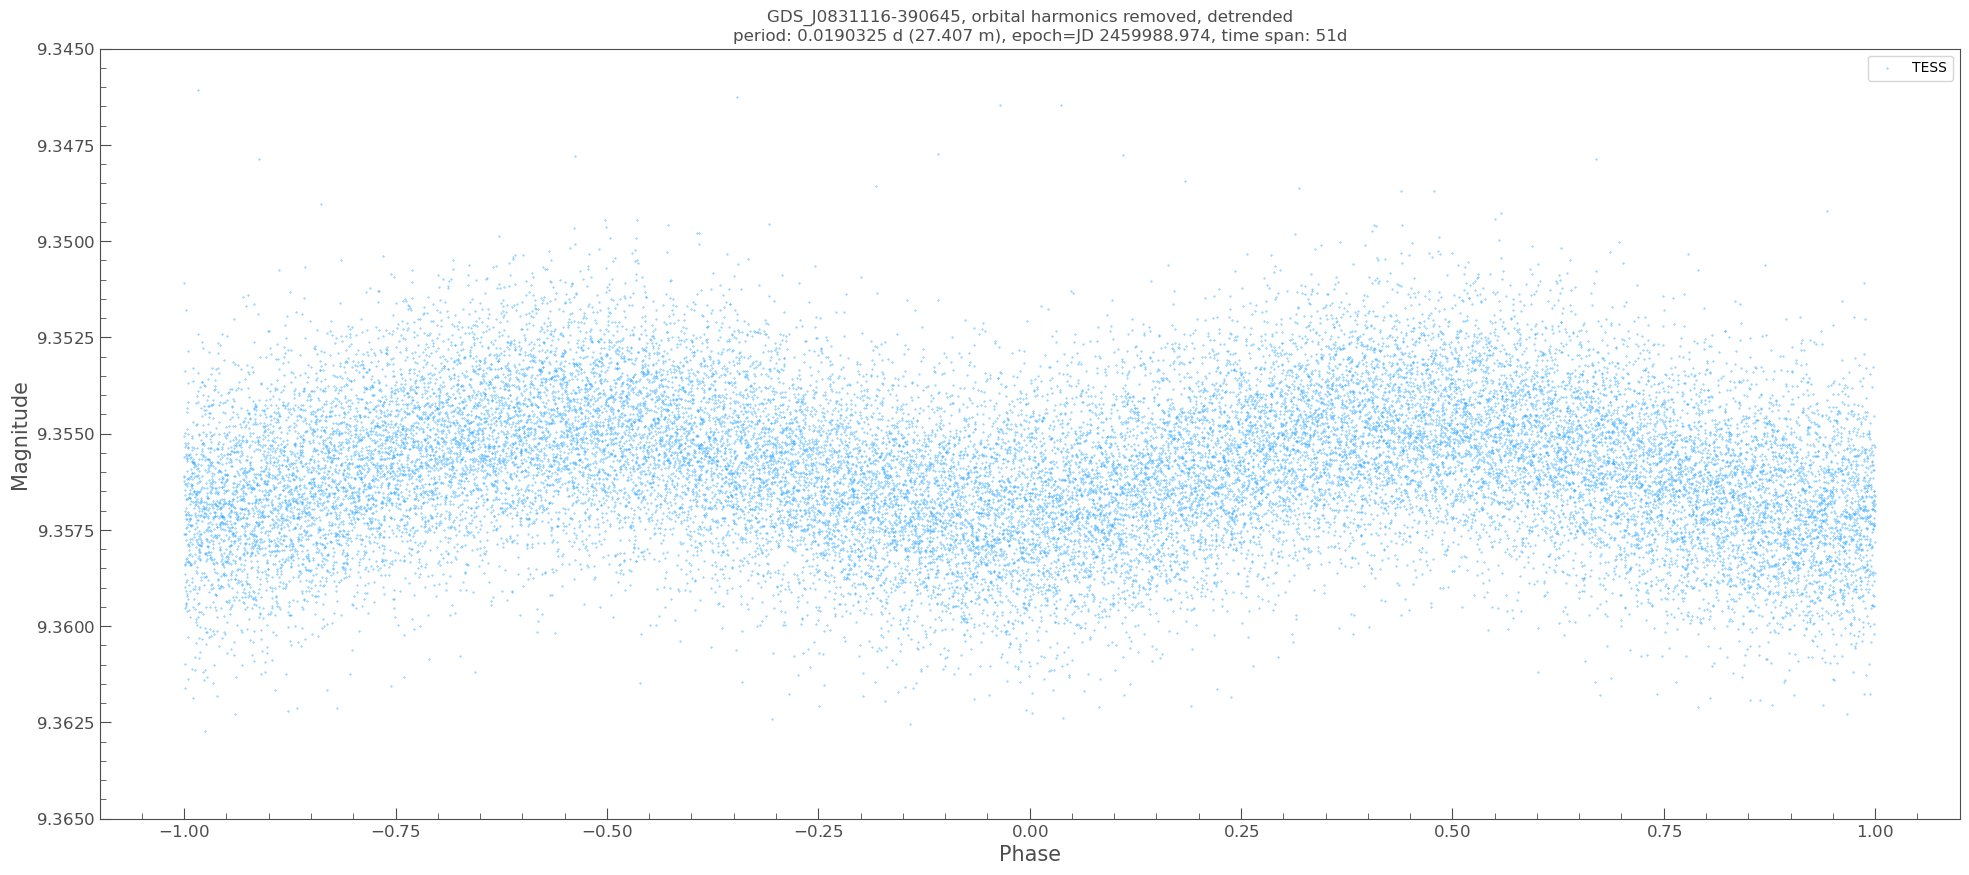

In [262]:
reload(lkem)

epoch_dsct_hjd = lke.to_hjd_utc(Time(epoch_dsct_btjd, format="btjd"), target_coord).value
epoch_dsct_hjd = round(epoch_dsct_hjd, 3)

lc_dsct_hjd = lke.convert_lc_time_to_hjd_utc(lc_dsct, target_coord=target_coord, cache_dir=lk_download_dir, cache_key=f"hjd_{tic}_61_62_dsct.txt")

ax, lc_dsct_f_dict = lkem.fold_n_plot_multi_bands(
    dict(TESS=lc_dsct_hjd),
    period=dsct_period, epoch=Time(epoch_dsct_hjd, format="jd", scale="utc"),
    phase_scale=2,
    figsize=(24, 10),
    target_name=f"{primary_name}, orbital harmonics removed, detrended");
ax.set_ylim(9.365, 9.345);

## VSX Report Table

In [120]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [261]:
import bibs_utils
reload(bibs_utils)


gaiadr3_name = "Gaia DR3 " + str(rs[0]["Source"])
other_names = (
    f"TIC {tic}"
    f",{gaiadr3_name}"  # in Gaia DR3 Variable
    ",2MASS J08311165-3906453,WISEA J083111.64-390645.3"  # from TIC, verified with SIMBAD / ASAS-SN Variable
    ",GSC 07662-00317,TYC 7662-317-1"  # SIMBAD
    # ASAS-SN V name: already in the entry
)

remarks = (
    f"Min I amplitude: {min_i_amplitude:.3f} TESS. Min II amplitude: {min_ii_amplitude:.3f} TESS."
    " Eclipse timing variations of amplitude 0.01 d."
    f" Ellipsoidal variations {ell_amplitude:.3f} TESS."
    f" DSCT period {dsct_period} d. with amplitude {dsct_amplitude} TESS."
)

revision_comment = (
    "Type, periods, epoch, ETV amplitude from Zhang, V.; et al., 2024. Magnitude range from ASAS-3."
    " Ellipsoidal variations, eclipse amplitudes, eclipse duration, DSCT amplitude from TESS."
    " Spectral type and position from Gaia DR3."
)

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA+DSCT",
    Spectral_Type="A",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{mag_max:.2f}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{mag_min:.2f}",
    Minimum_Magnitude_band="V",
    Minimum_Is_Amplitude=False,
    Period=period,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr / 24 / period:.0f}",
    Discoverer="",  #  The original entry has no discoverer
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name="Zhang, V.; et al., 2024, TIC 184 743 498: the first tri-axial stellar pulsator",
    Reference0_Bib="2024MNRAS.528.3378Z",
    Reference2_Name=BIBS.TESS_SPOC_N,
    Reference2_Bib=BIBS.TESS_SPOC_B,
    Reference1_Name=BIBS.TESS_N,
    Reference1_Bib=BIBS.TESS_B,
    Reference4_Name=BIBS.ASAS3_N,
    Reference4_Bib=BIBS.ASAS3_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
tic184743498_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from  ASAS-3 and TESS, shifted to ASAS-3.
tic184743498_phase_plot_pulsation.png : Pulsation Phase Plot from detrended 2-minute cadence TESS.
""")


Other Names (1 line each):
TIC 184743498
Gaia DR3 5529419447534403200
2MASS J08311165-3906453
WISEA J083111.64-390645.3
GSC 07662-00317
TYC 7662-317-1

Min I amplitude: 0.040 TESS. Min II amplitude: 0.018 TESS. Eclipse timing variations of amplitude 0.01 d. Ellipsoidal variations 0.035 TESS. DSCT period 0.0190325 d. with amplitude 0.003 TESS.

Type, periods, epoch, ETV amplitude from Zhang, V.; et al., 2024. Magnitude range from ASAS-3. Ellipsoidal variations, eclipse amplitudes, eclipse duration, DSCT amplitude from TESS. Spectral type and position from Gaia DR3.


,Field,Value
0,Position,"127.79853909992, -39.11261686244"
1,Primary_Name,GDS_J0831116-390645
2,Other_Names,"TIC 184743498,Gaia DR3 5529419447534403200,2MASS J08311165-3906453,WISEA J083111.64-390645.3,GSC 07662-00317,TYC 7662-317-1"
3,Variable_Type,EA+DSCT
4,Spectral_Type,A
5,Spectral_Type_Uncertain,False
6,Maximum_Magnitude,9.58
7,Maximum_Magnitude_band,V
8,Minimum_Magnitude,9.66
9,Minimum_Magnitude_band,V



tic184743498_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from  ASAS-3 and TESS, shifted to ASAS-3.
tic184743498_phase_plot_pulsation.png : Pulsation Phase Plot from detrended 2-minute cadence TESS.

